In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import HTML
import pandas as pd
import data_utils.data_utils_celeba_pytorch5 as data_utils
import data_utils.network_tuning_valid as network_tuning
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
import pickle
# Load functions
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout2d, MaxPool2d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [20]:
pwd

'/Users/MartinJohnsen/Documents/Martin Johnsen/MMC/3. Semester/Deep Learning/Projects/Algorithmic fairness/AlgorithmicFairness'

In [21]:
IMAGE_SHAPE = [73,60,3]
# Root directory for dataset
#dataroot = 'C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness'
# Paths to data
VALID_PATH = "Data/valid.csv"  
IMAGE_PATHS = "/Users/MartinJohnsen/Documents/Martin Johnsen/MMC/3. Semester/Deep Learning/Projects/Algorithmic fairness/Data/celebA_resize3"
TARGET_COL = 'Smiling' #'Smiling'
NUM_CLASSES = 2

# valid data
data_valid = data_utils.CelebADataset(VALID_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)

In [16]:
attributes = pd.read_csv('Data/list_attr_celeba.txt', sep=" ")
attributes.drop('Unnamed: 41',axis=1, inplace=True)
partition = pd.read_csv('Data/list_eval_partition.txt', sep=" ", header=None, names=['im_id','partition'])
matched = attributes.set_index('im_id').join(partition.set_index('im_id')).replace(-1,0)

valid_df = matched[matched['partition']==1]

In [25]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


In [24]:
criterion = nn.CrossEntropyLoss()          #<-- Your code here.   

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

In [23]:
# Function to get label
def get_labels(batch):
    return get_variable(Variable(batch['target']))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(batch['image']))
    }

In [2]:
# Read dataframe with training metrics
df = pd.read_pickle('models/aws_models/run4__df.pkl') #e.g. pd.read_pickle('df.pkl')

In [5]:
df.loc[2,'activations']

[<function torch.nn.functional.relu(input, inplace=False)>,
 <function torch.nn.functional.relu(input, inplace=False)>,
 <function torch.nn.functional.relu(input, inplace=False)>,
 <function torch.nn.functional.relu(input, inplace=False)>]

In [6]:
df

layers                                        activations  \
2       2  [<function relu at 0x119cc4f28>, <function rel...   

   conv_out_channels  kernel_size  conv_stride  maxpool  dropout  batchnorm  \
2                 32            5            1        2      0.2       True   

  optimizer  learning_rate  weight_decay  batch_size  num_epochs  \
2      Adam          0.001          0.01         128           5   

            net                                         train_loss  \
2  run4__model2  [0.7738814353942871, 1.319926142692566, 1.2189...   

                                          train_accs  \
2  [0.46875, 0.4765625, 0.3515625, 0.4609375, 0.5...   

                                    valid_train_loss  \
2  [3.985553026199341, 0.4203346371650696, 0.4207...   

                                    valid_train_accs valid_loss valid_accs  
2  [0.46655258536338806, 0.8093823790550232, 0.80...   0.366079   0.834902

In [9]:
np.mean(df.loc[2,'train_accs'][-300:])

0.8334027777115504

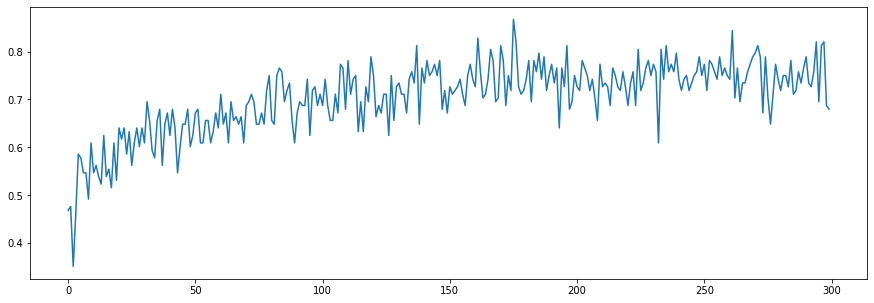

In [10]:
plt.figure(figsize=(15,5))
plt.plot(df.loc[2,'train_accs'][0:300])
ind = [300*i for i in range(0,22)]
#plt.plot(ind,df.loc[3,'valid_train_accs'])

ValueError: x and y must have same first dimension, but have shapes (22,) and (36,)

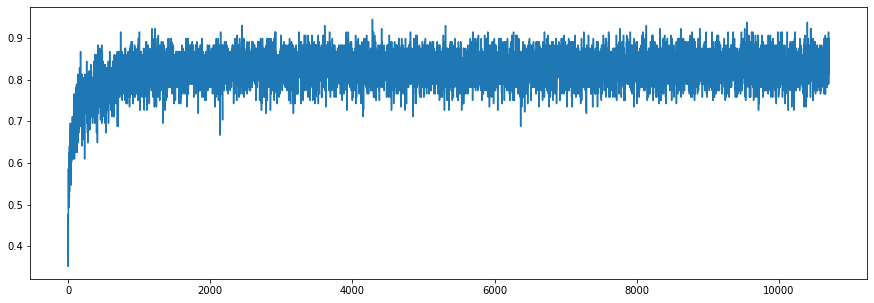

In [11]:
plt.figure(figsize=(15,5))
plt.plot(df.loc[2,'train_accs'])
ind = [300*i for i in range(0,22)]
plt.plot(ind,df.loc[2,'valid_train_accs'])

In [12]:
# Change i to the model number you want to load
i = 2
IMAGE_SHAPE = [73,60,3]
layers = df.loc[i,'layers']
activations = df.loc[i,'activations']
conv_out_channels = df.loc[i,'conv_out_channels']
kernel_size = df.loc[i,'kernel_size']
conv_stride = df.loc[i,'conv_stride']
maxpool = int(df.loc[i,'maxpool'])
dropout = df.loc[i,'dropout']
batchnorm = df.loc[i,'batchnorm']
optimizer = df.loc[i,'optimizer']
learning_rate = df.loc[i,'learning_rate']
weight_decay = df.loc[i,'weight_decay']
batch_size = int(df.loc[i,'batch_size'])
num_epochs = df.loc[i,'num_epochs']

net = network_tuning.tune_architecture(layers, activations, IMAGE_SHAPE, conv_out_channels, kernel_size,conv_stride, maxpool, dropout, batchnorm)

In [14]:
# Load network, choose the model i
net.load_state_dict(torch.load('models/aws_models/run4__model2.dms',map_location=torch.device('cpu'))) # e.g. net.load_state_dict(torch.load('model1'))
net.eval()

Net(
  (conv_1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (l_out): Linear(in_features=11520, out_features=2, bias=False)
)

In [17]:
#dataframe for saving predictions
valid_predictions = valid_df.astype(object)
valid_predictions.loc[:,'target'] = valid_predictions.loc[:,'Smiling']
valid_predictions.drop(['Smiling','partition'],axis=1)
valid_predictions['output'] = np.nan
valid_predictions['labels_argmax'] = np.nan
valid_predictions['accuracy'] = np.nan
valid_predictions['criterion'] = np.nan

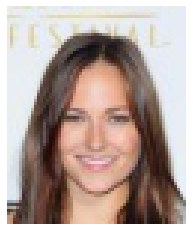

True Label:  tensor(1)
Model output:  tensor([-2.3418,  2.3416])
File name:  176995.jpg


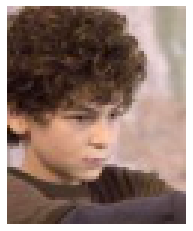

True Label:  tensor(0)
Model output:  tensor([ 1.9472, -1.9469])
File name:  179295.jpg


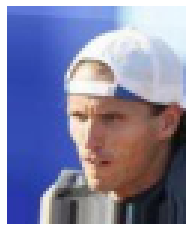

True Label:  tensor(0)
Model output:  tensor([ 0.8498, -0.8492])
File name:  174734.jpg


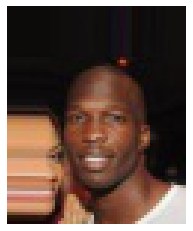

True Label:  tensor(1)
Model output:  tensor([-0.9249,  0.9256])
File name:  180338.jpg


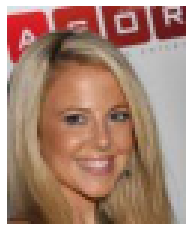

True Label:  tensor(1)
Model output:  tensor([-2.3792,  2.3787])
File name:  174820.jpg


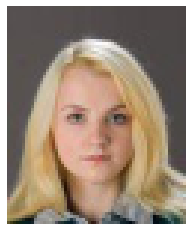

True Label:  tensor(0)
Model output:  tensor([ 1.6425, -1.6429])
File name:  174364.jpg


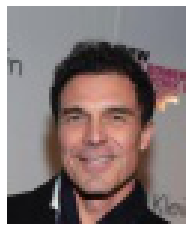

True Label:  tensor(1)
Model output:  tensor([ 0.1958, -0.1949])
File name:  177006.jpg


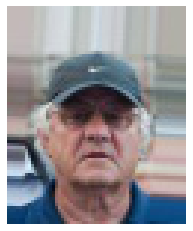

True Label:  tensor(0)
Model output:  tensor([ 0.6473, -0.6468])
File name:  170682.jpg


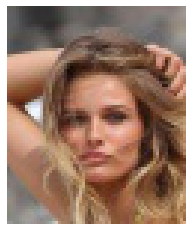

True Label:  tensor(0)
Model output:  tensor([ 0.2186, -0.2184])
File name:  163885.jpg


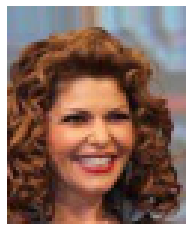

True Label:  tensor(1)
Model output:  tensor([-1.9484,  1.9482])
File name:  171749.jpg


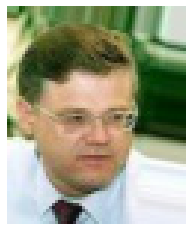

True Label:  tensor(0)
Model output:  tensor([ 1.7066, -1.7069])
File name:  179792.jpg


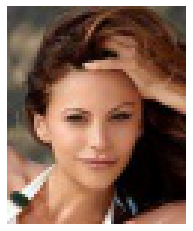

True Label:  tensor(0)
Model output:  tensor([-0.0593,  0.0589])
File name:  173762.jpg


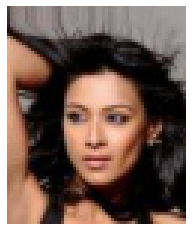

True Label:  tensor(0)
Model output:  tensor([-0.2102,  0.2107])
File name:  177770.jpg


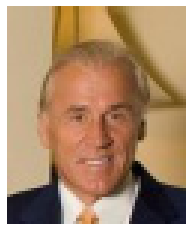

True Label:  tensor(1)
Model output:  tensor([ 0.3357, -0.3356])
File name:  180721.jpg


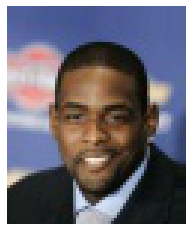

True Label:  tensor(1)
Model output:  tensor([-0.1001,  0.1007])
File name:  178233.jpg


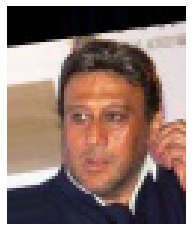

True Label:  tensor(0)
Model output:  tensor([ 0.8633, -0.8628])
File name:  177393.jpg


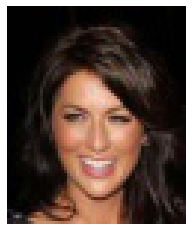

True Label:  tensor(1)
Model output:  tensor([-2.6125,  2.6120])
File name:  165363.jpg


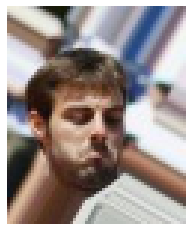

True Label:  tensor(0)
Model output:  tensor([ 1.7700, -1.7700])
File name:  174095.jpg


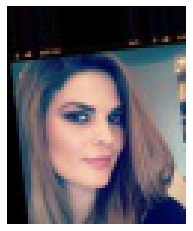

True Label:  tensor(1)
Model output:  tensor([ 1.2971, -1.2971])
File name:  166817.jpg


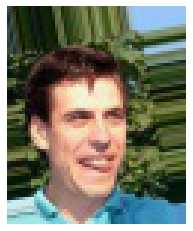

True Label:  tensor(1)
Model output:  tensor([ 0.5953, -0.5947])
File name:  167627.jpg


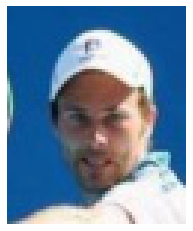

True Label:  tensor(0)
Model output:  tensor([ 1.3963, -1.3958])
File name:  176025.jpg


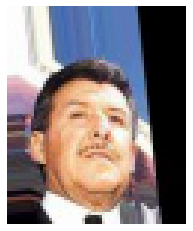

True Label:  tensor(0)
Model output:  tensor([ 0.9583, -0.9594])
File name:  180151.jpg


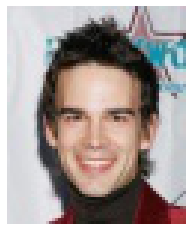

True Label:  tensor(1)
Model output:  tensor([-0.2480,  0.2483])
File name:  167946.jpg


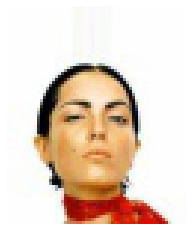

True Label:  tensor(0)
Model output:  tensor([ 2.8024, -2.8028])
File name:  167806.jpg


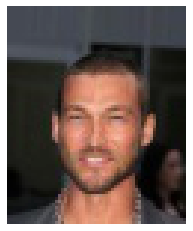

True Label:  tensor(1)
Model output:  tensor([ 0.9066, -0.9056])
File name:  165314.jpg


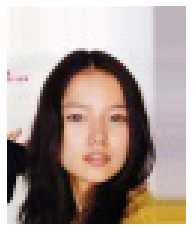

True Label:  tensor(0)
Model output:  tensor([ 1.4328, -1.4327])
File name:  181313.jpg


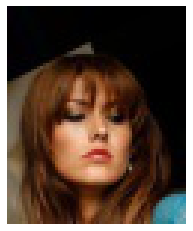

True Label:  tensor(0)
Model output:  tensor([ 1.8515, -1.8516])
File name:  177519.jpg


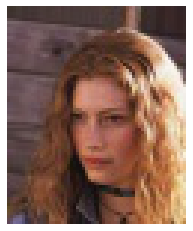

True Label:  tensor(0)
Model output:  tensor([ 0.5451, -0.5455])
File name:  180091.jpg


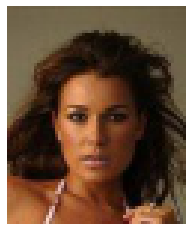

True Label:  tensor(0)
Model output:  tensor([ 1.3092, -1.3095])
File name:  170149.jpg


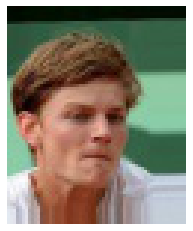

True Label:  tensor(0)
Model output:  tensor([ 1.1319, -1.1322])
File name:  167666.jpg


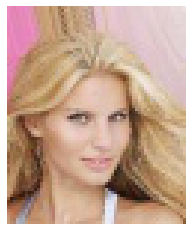

True Label:  tensor(1)
Model output:  tensor([ 0.1637, -0.1642])
File name:  172203.jpg


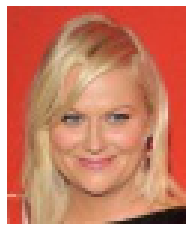

True Label:  tensor(1)
Model output:  tensor([-3.1364,  3.1364])
File name:  163957.jpg


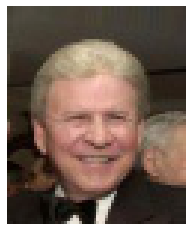

True Label:  tensor(1)
Model output:  tensor([-1.5202,  1.5201])
File name:  177380.jpg


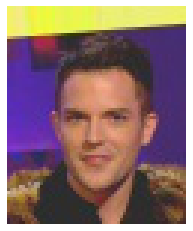

True Label:  tensor(0)
Model output:  tensor([-0.1926,  0.1926])
File name:  175356.jpg


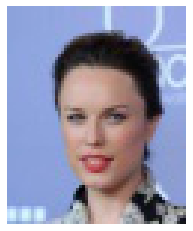

True Label:  tensor(1)
Model output:  tensor([ 0.2495, -0.2489])
File name:  181880.jpg


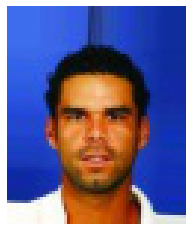

True Label:  tensor(0)
Model output:  tensor([ 1.3076, -1.3069])
File name:  166235.jpg


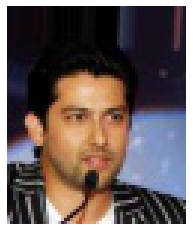

True Label:  tensor(0)
Model output:  tensor([ 1.6519, -1.6518])
File name:  181259.jpg


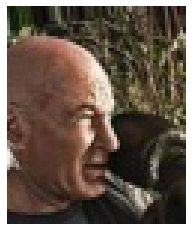

True Label:  tensor(0)
Model output:  tensor([ 0.7079, -0.7075])
File name:  179015.jpg


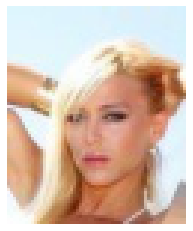

True Label:  tensor(0)
Model output:  tensor([ 1.4893, -1.4893])
File name:  179578.jpg


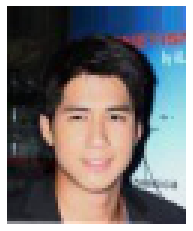

True Label:  tensor(1)
Model output:  tensor([ 1.4345, -1.4348])
File name:  179496.jpg


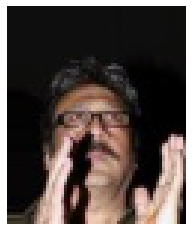

True Label:  tensor(0)
Model output:  tensor([-0.4138,  0.4147])
File name:  175056.jpg


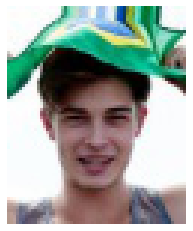

True Label:  tensor(1)
Model output:  tensor([ 0.7889, -0.7888])
File name:  182361.jpg


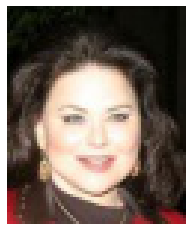

True Label:  tensor(1)
Model output:  tensor([-0.9265,  0.9264])
File name:  168477.jpg


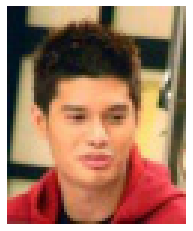

True Label:  tensor(1)
Model output:  tensor([ 1.8393, -1.8397])
File name:  171318.jpg


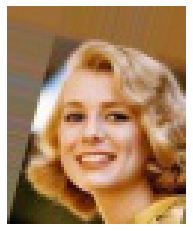

True Label:  tensor(1)
Model output:  tensor([-1.1769,  1.1768])
File name:  170217.jpg


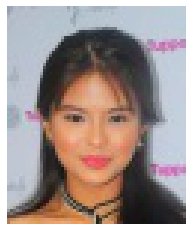

True Label:  tensor(1)
Model output:  tensor([ 0.2456, -0.2459])
File name:  171705.jpg


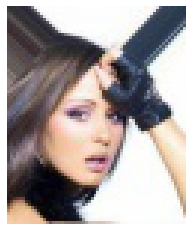

True Label:  tensor(0)
Model output:  tensor([ 2.1904, -2.1904])
File name:  172604.jpg


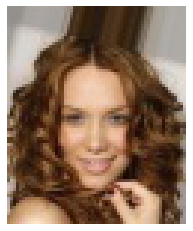

True Label:  tensor(1)
Model output:  tensor([-1.9457,  1.9458])
File name:  179254.jpg


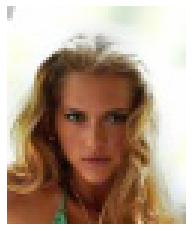

True Label:  tensor(0)
Model output:  tensor([ 1.6326, -1.6325])
File name:  175119.jpg


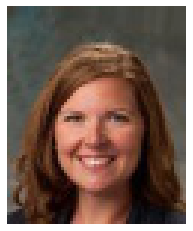

True Label:  tensor(1)
Model output:  tensor([-1.9251,  1.9253])
File name:  177841.jpg


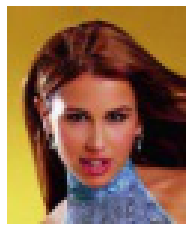

True Label:  tensor(0)
Model output:  tensor([ 0.4338, -0.4334])
File name:  168813.jpg


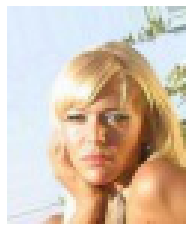

True Label:  tensor(0)
Model output:  tensor([ 1.4303, -1.4300])
File name:  181919.jpg


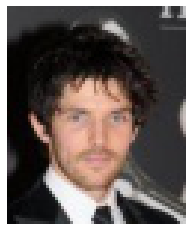

True Label:  tensor(0)
Model output:  tensor([ 2.2084, -2.2079])
File name:  168968.jpg


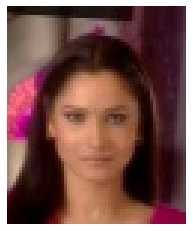

True Label:  tensor(0)
Model output:  tensor([ 0.2769, -0.2775])
File name:  174783.jpg


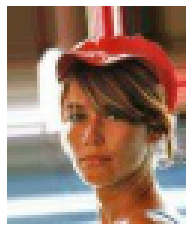

True Label:  tensor(0)
Model output:  tensor([ 0.6780, -0.6782])
File name:  171454.jpg


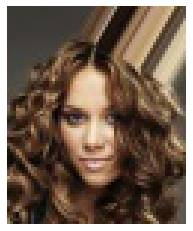

True Label:  tensor(0)
Model output:  tensor([-0.1875,  0.1880])
File name:  177550.jpg


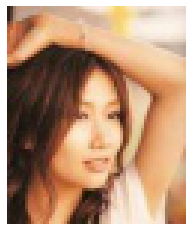

True Label:  tensor(0)
Model output:  tensor([ 0.5635, -0.5632])
File name:  166364.jpg


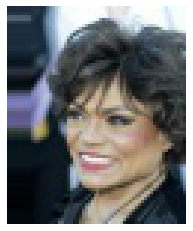

True Label:  tensor(1)
Model output:  tensor([-1.3724,  1.3729])
File name:  167442.jpg


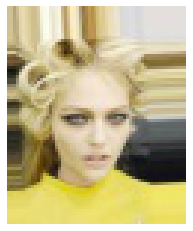

True Label:  tensor(0)
Model output:  tensor([ 0.1934, -0.1937])
File name:  166232.jpg


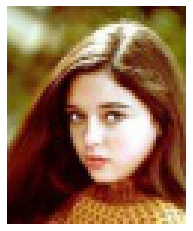

True Label:  tensor(0)
Model output:  tensor([ 0.6981, -0.6979])
File name:  171094.jpg


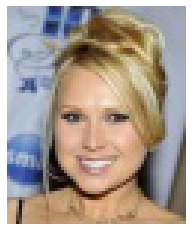

True Label:  tensor(1)
Model output:  tensor([-2.0693,  2.0698])
File name:  171172.jpg


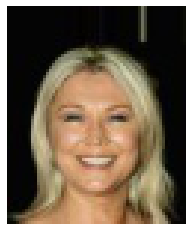

True Label:  tensor(1)
Model output:  tensor([-2.4664,  2.4662])
File name:  168020.jpg


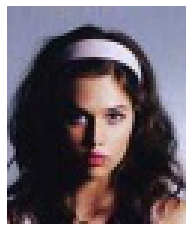

True Label:  tensor(0)
Model output:  tensor([ 1.4285, -1.4282])
File name:  177120.jpg


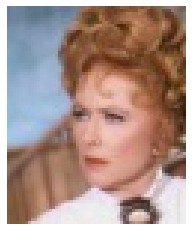

True Label:  tensor(0)
Model output:  tensor([ 1.0217, -1.0222])
File name:  170532.jpg


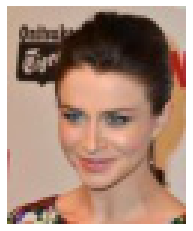

True Label:  tensor(1)
Model output:  tensor([-2.0369,  2.0370])
File name:  169588.jpg


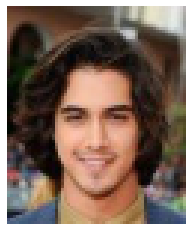

True Label:  tensor(1)
Model output:  tensor([ 0.4137, -0.4132])
File name:  164953.jpg


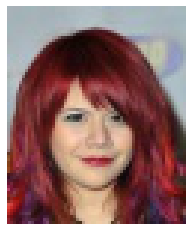

True Label:  tensor(1)
Model output:  tensor([-0.7413,  0.7413])
File name:  174691.jpg


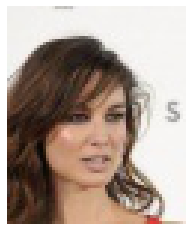

True Label:  tensor(0)
Model output:  tensor([ 0.3536, -0.3538])
File name:  175550.jpg


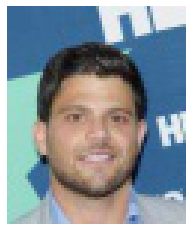

True Label:  tensor(1)
Model output:  tensor([ 0.7575, -0.7574])
File name:  165555.jpg


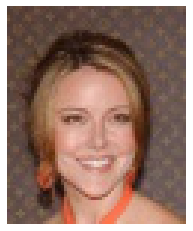

True Label:  tensor(1)
Model output:  tensor([-2.3219,  2.3212])
File name:  178197.jpg


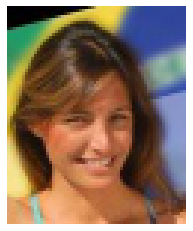

True Label:  tensor(1)
Model output:  tensor([-0.6336,  0.6339])
File name:  164276.jpg


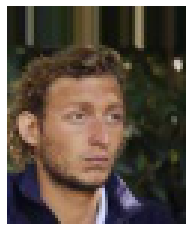

True Label:  tensor(0)
Model output:  tensor([ 1.7244, -1.7244])
File name:  174588.jpg


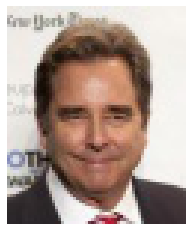

True Label:  tensor(1)
Model output:  tensor([-0.6181,  0.6183])
File name:  168446.jpg


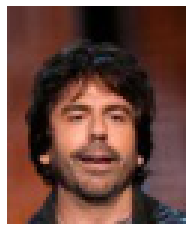

True Label:  tensor(0)
Model output:  tensor([ 1.3553, -1.3551])
File name:  175593.jpg


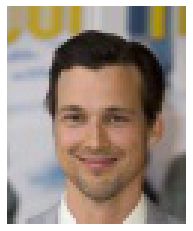

True Label:  tensor(1)
Model output:  tensor([-1.5022,  1.5025])
File name:  166978.jpg


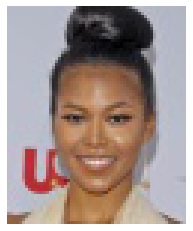

True Label:  tensor(1)
Model output:  tensor([-2.3538,  2.3536])
File name:  180907.jpg


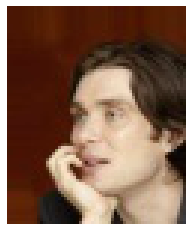

True Label:  tensor(0)
Model output:  tensor([ 0.7946, -0.7943])
File name:  168548.jpg


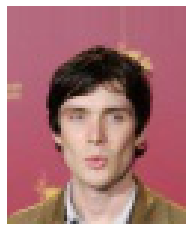

True Label:  tensor(0)
Model output:  tensor([ 1.4489, -1.4489])
File name:  180776.jpg


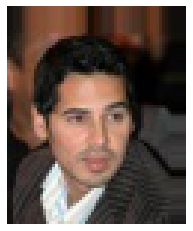

True Label:  tensor(0)
Model output:  tensor([ 1.5579, -1.5576])
File name:  168748.jpg


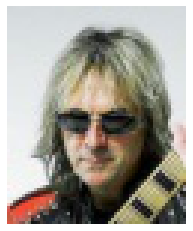

True Label:  tensor(0)
Model output:  tensor([ 1.4934, -1.4930])
File name:  173848.jpg


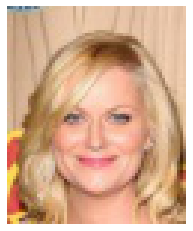

True Label:  tensor(1)
Model output:  tensor([-2.2842,  2.2838])
File name:  168524.jpg


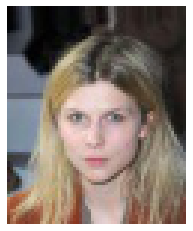

True Label:  tensor(0)
Model output:  tensor([ 1.1318, -1.1322])
File name:  165055.jpg


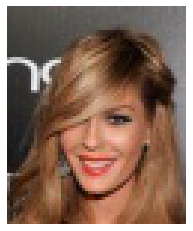

True Label:  tensor(1)
Model output:  tensor([-2.1414,  2.1416])
File name:  170466.jpg


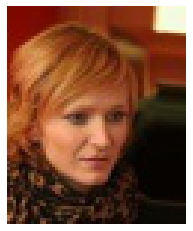

True Label:  tensor(0)
Model output:  tensor([ 0.3413, -0.3410])
File name:  163083.jpg


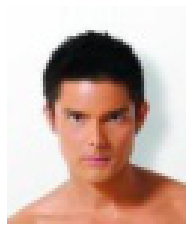

True Label:  tensor(0)
Model output:  tensor([ 1.5209, -1.5212])
File name:  168831.jpg


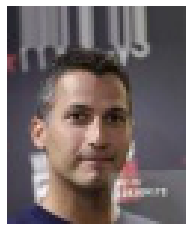

True Label:  tensor(0)
Model output:  tensor([ 1.1724, -1.1724])
File name:  169085.jpg


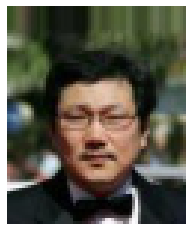

True Label:  tensor(0)
Model output:  tensor([ 0.1316, -0.1315])
File name:  181925.jpg


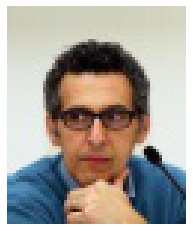

True Label:  tensor(0)
Model output:  tensor([ 1.8514, -1.8515])
File name:  172299.jpg


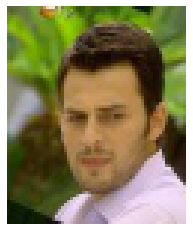

True Label:  tensor(0)
Model output:  tensor([ 1.8930, -1.8931])
File name:  176194.jpg


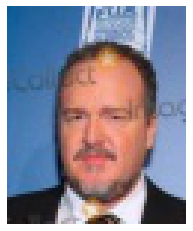

True Label:  tensor(0)
Model output:  tensor([ 1.1859, -1.1853])
File name:  171898.jpg


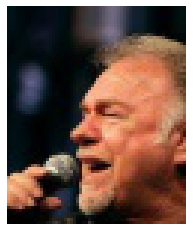

True Label:  tensor(0)
Model output:  tensor([-0.5348,  0.5346])
File name:  167748.jpg


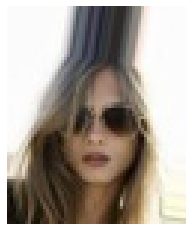

True Label:  tensor(0)
Model output:  tensor([ 1.7395, -1.7397])
File name:  169547.jpg


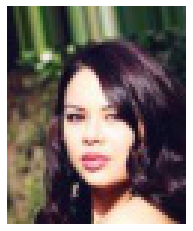

True Label:  tensor(0)
Model output:  tensor([ 0.8017, -0.8011])
File name:  178098.jpg


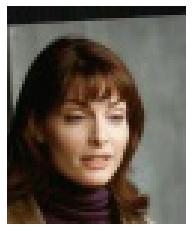

True Label:  tensor(0)
Model output:  tensor([ 1.1768, -1.1768])
File name:  169122.jpg


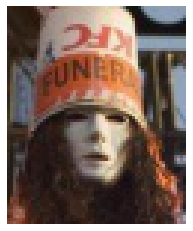

True Label:  tensor(0)
Model output:  tensor([ 0.7115, -0.7120])
File name:  163169.jpg


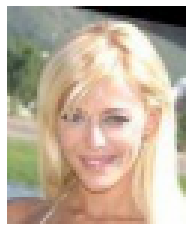

True Label:  tensor(1)
Model output:  tensor([-0.6464,  0.6457])
File name:  163167.jpg


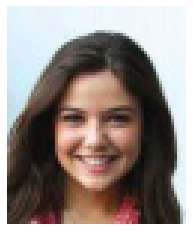

True Label:  tensor(1)
Model output:  tensor([-1.4905,  1.4914])
File name:  167003.jpg


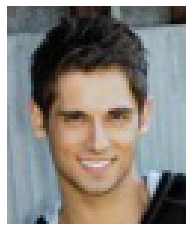

True Label:  tensor(1)
Model output:  tensor([-0.9009,  0.9013])
File name:  175723.jpg


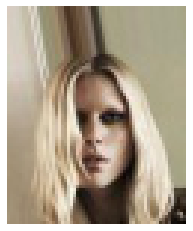

True Label:  tensor(0)
Model output:  tensor([ 0.7755, -0.7755])
File name:  165854.jpg


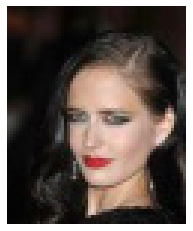

True Label:  tensor(0)
Model output:  tensor([-0.1288,  0.1288])
File name:  178713.jpg


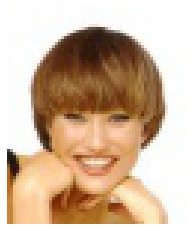

True Label:  tensor(1)
Model output:  tensor([-0.8303,  0.8307])
File name:  171173.jpg


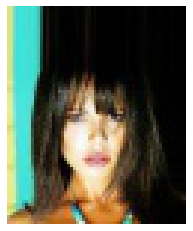

True Label:  tensor(0)
Model output:  tensor([ 0.9893, -0.9891])
File name:  175000.jpg


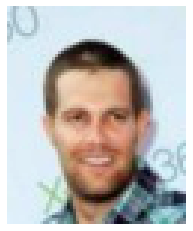

True Label:  tensor(1)
Model output:  tensor([-0.2181,  0.2185])
File name:  163954.jpg


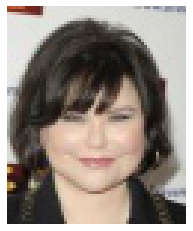

True Label:  tensor(1)
Model output:  tensor([-1.2548,  1.2547])
File name:  175741.jpg


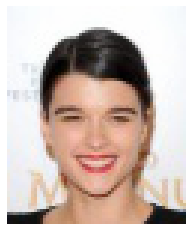

True Label:  tensor(1)
Model output:  tensor([-0.8295,  0.8296])
File name:  174126.jpg


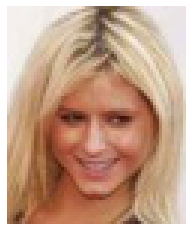

True Label:  tensor(1)
Model output:  tensor([-2.4681,  2.4679])
File name:  164169.jpg


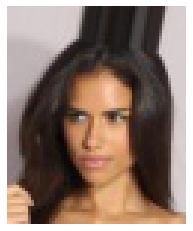

True Label:  tensor(0)
Model output:  tensor([ 0.4141, -0.4138])
File name:  165303.jpg


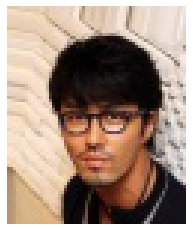

True Label:  tensor(0)
Model output:  tensor([ 1.4077, -1.4077])
File name:  180256.jpg


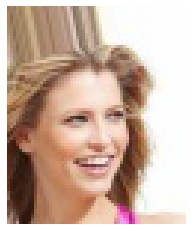

True Label:  tensor(1)
Model output:  tensor([-0.2924,  0.2928])
File name:  173887.jpg


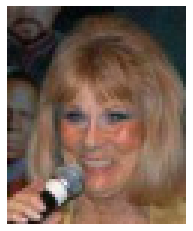

True Label:  tensor(1)
Model output:  tensor([-1.6411,  1.6409])
File name:  177202.jpg


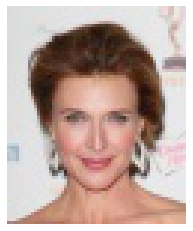

True Label:  tensor(1)
Model output:  tensor([-0.6677,  0.6668])
File name:  178353.jpg


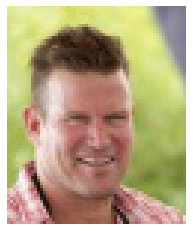

True Label:  tensor(1)
Model output:  tensor([-1.0301,  1.0303])
File name:  172176.jpg


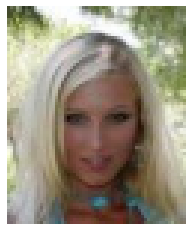

True Label:  tensor(1)
Model output:  tensor([-0.0625,  0.0623])
File name:  179622.jpg


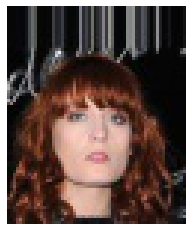

True Label:  tensor(0)
Model output:  tensor([ 1.5922, -1.5925])
File name:  177894.jpg


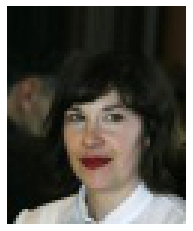

True Label:  tensor(0)
Model output:  tensor([ 0.2976, -0.2971])
File name:  163908.jpg


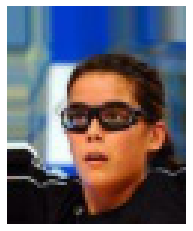

True Label:  tensor(0)
Model output:  tensor([ 1.4302, -1.4294])
File name:  177365.jpg


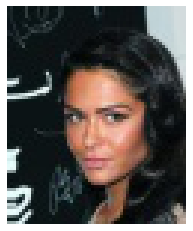

True Label:  tensor(0)
Model output:  tensor([-0.9036,  0.9044])
File name:  170728.jpg


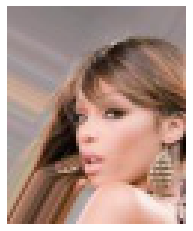

True Label:  tensor(0)
Model output:  tensor([-0.2482,  0.2479])
File name:  167304.jpg


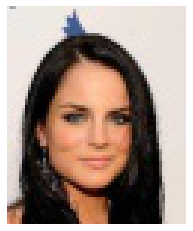

True Label:  tensor(1)
Model output:  tensor([-0.7455,  0.7460])
File name:  168457.jpg


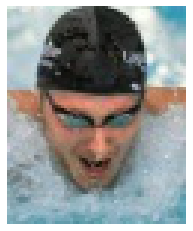

True Label:  tensor(1)
Model output:  tensor([ 1.5903, -1.5891])
File name:  176385.jpg


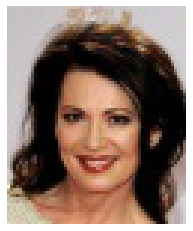

True Label:  tensor(1)
Model output:  tensor([-2.3080,  2.3081])
File name:  165801.jpg


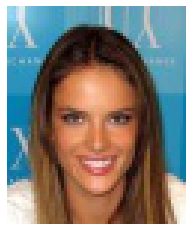

True Label:  tensor(1)
Model output:  tensor([-3.1300,  3.1300])
File name:  172976.jpg


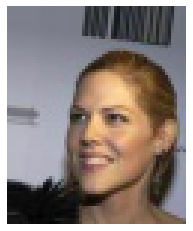

True Label:  tensor(1)
Model output:  tensor([-1.2208,  1.2214])
File name:  170034.jpg


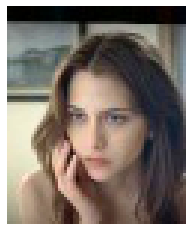

True Label:  tensor(0)
Model output:  tensor([ 0.9072, -0.9068])
File name:  179668.jpg


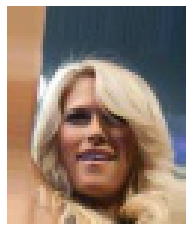

True Label:  tensor(1)
Model output:  tensor([ 0.0281, -0.0286])
File name:  174787.jpg


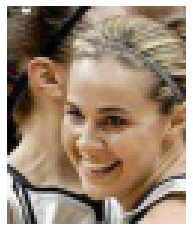

True Label:  tensor(1)
Model output:  tensor([ 0.1917, -0.1907])
File name:  169444.jpg


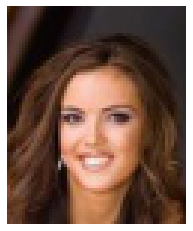

True Label:  tensor(1)
Model output:  tensor([-1.7414,  1.7416])
File name:  170643.jpg


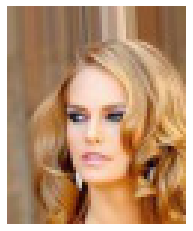

True Label:  tensor(0)
Model output:  tensor([ 0.6531, -0.6529])
File name:  176457.jpg


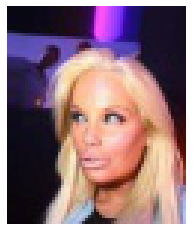

True Label:  tensor(0)
Model output:  tensor([-0.1296,  0.1301])
File name:  170656.jpg


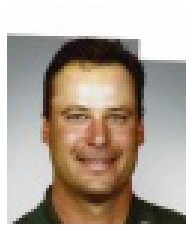

True Label:  tensor(1)
Model output:  tensor([ 0.4872, -0.4867])
File name:  166604.jpg


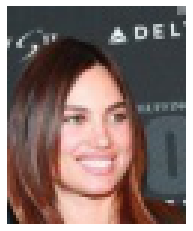

True Label:  tensor(1)
Model output:  tensor([-1.3171,  1.3175])
File name:  178590.jpg


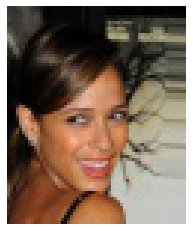

True Label:  tensor(1)
Model output:  tensor([-1.0181,  1.0182])
File name:  171936.jpg


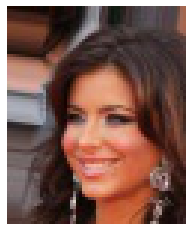

True Label:  tensor(1)
Model output:  tensor([-2.7232,  2.7236])
File name:  171079.jpg


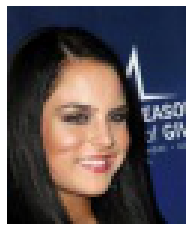

True Label:  tensor(1)
Model output:  tensor([-1.4481,  1.4482])
File name:  174519.jpg


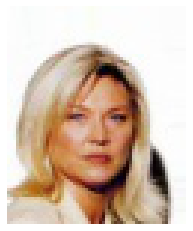

True Label:  tensor(0)
Model output:  tensor([ 0.9238, -0.9240])
File name:  166099.jpg


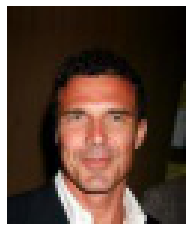

True Label:  tensor(1)
Model output:  tensor([ 0.9256, -0.9246])
File name:  163670.jpg


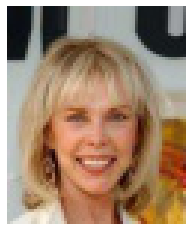

True Label:  tensor(1)
Model output:  tensor([-1.6274,  1.6273])
File name:  163419.jpg


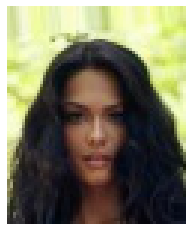

True Label:  tensor(0)
Model output:  tensor([ 1.2860, -1.2867])
File name:  176120.jpg


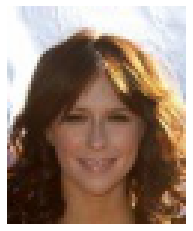

True Label:  tensor(1)
Model output:  tensor([-1.8632,  1.8631])
File name:  168953.jpg


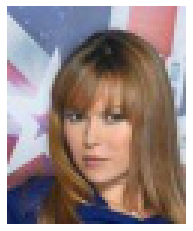

True Label:  tensor(0)
Model output:  tensor([ 0.3336, -0.3337])
File name:  177905.jpg


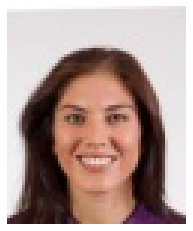

True Label:  tensor(1)
Model output:  tensor([-2.8947,  2.8945])
File name:  180828.jpg


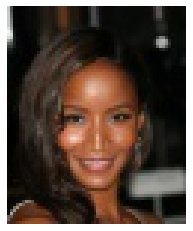

True Label:  tensor(1)
Model output:  tensor([-2.9617,  2.9619])
File name:  174362.jpg


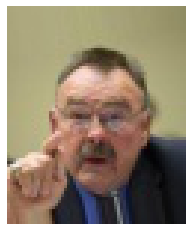

True Label:  tensor(0)
Model output:  tensor([ 1.2497, -1.2493])
File name:  167863.jpg


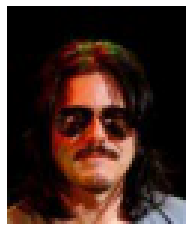

True Label:  tensor(0)
Model output:  tensor([ 0.7588, -0.7586])
File name:  163778.jpg


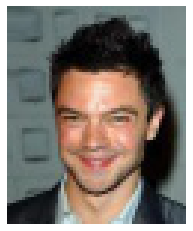

True Label:  tensor(1)
Model output:  tensor([-1.1045,  1.1050])
File name:  171276.jpg


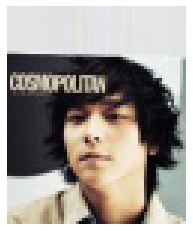

True Label:  tensor(0)
Model output:  tensor([ 0.3970, -0.3973])
File name:  176535.jpg


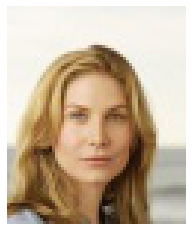

True Label:  tensor(0)
Model output:  tensor([ 0.6500, -0.6502])
File name:  182545.jpg


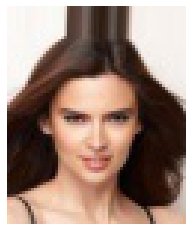

True Label:  tensor(1)
Model output:  tensor([ 0.4617, -0.4613])
File name:  166222.jpg


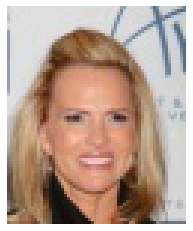

True Label:  tensor(1)
Model output:  tensor([-0.8212,  0.8210])
File name:  173822.jpg


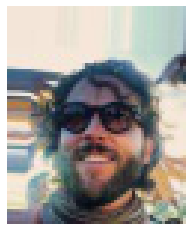

True Label:  tensor(1)
Model output:  tensor([ 1.1230, -1.1229])
File name:  181475.jpg


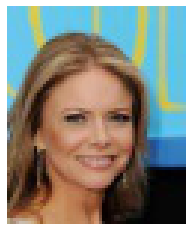

True Label:  tensor(1)
Model output:  tensor([-2.2430,  2.2428])
File name:  180861.jpg


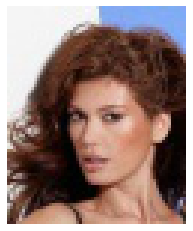

True Label:  tensor(0)
Model output:  tensor([ 0.0460, -0.0451])
File name:  166278.jpg


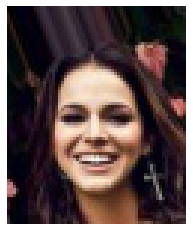

True Label:  tensor(1)
Model output:  tensor([-0.2908,  0.2910])
File name:  176295.jpg


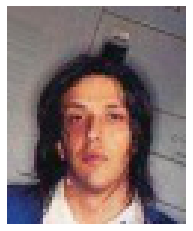

True Label:  tensor(0)
Model output:  tensor([ 0.9156, -0.9163])
File name:  177347.jpg


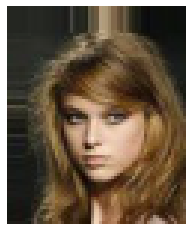

True Label:  tensor(0)
Model output:  tensor([ 0.8549, -0.8542])
File name:  178046.jpg


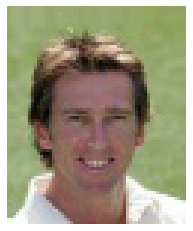

True Label:  tensor(1)
Model output:  tensor([ 0.3255, -0.3257])
File name:  170698.jpg


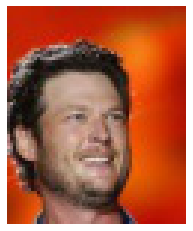

True Label:  tensor(1)
Model output:  tensor([ 0.9277, -0.9280])
File name:  168343.jpg


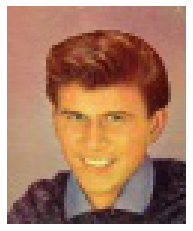

True Label:  tensor(1)
Model output:  tensor([ 0.2533, -0.2529])
File name:  166874.jpg


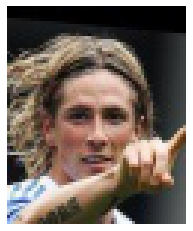

True Label:  tensor(0)
Model output:  tensor([ 0.8703, -0.8704])
File name:  164131.jpg


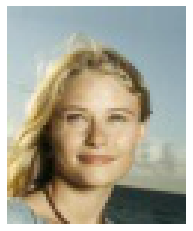

True Label:  tensor(1)
Model output:  tensor([ 0.4494, -0.4505])
File name:  166037.jpg


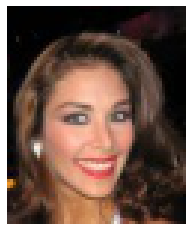

True Label:  tensor(1)
Model output:  tensor([-1.9108,  1.9099])
File name:  169101.jpg


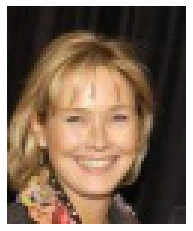

True Label:  tensor(1)
Model output:  tensor([-3.4182,  3.4183])
File name:  164765.jpg


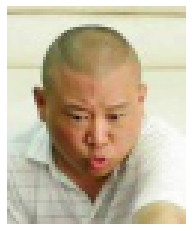

True Label:  tensor(0)
Model output:  tensor([ 1.8089, -1.8087])
File name:  173008.jpg


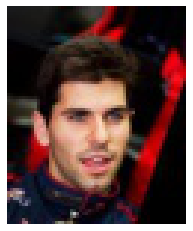

True Label:  tensor(0)
Model output:  tensor([ 1.4902, -1.4898])
File name:  169485.jpg


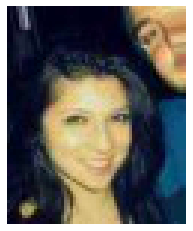

True Label:  tensor(0)
Model output:  tensor([-0.5182,  0.5176])
File name:  173903.jpg


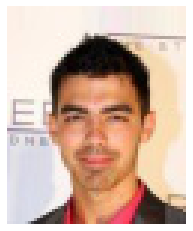

True Label:  tensor(1)
Model output:  tensor([ 1.3645, -1.3643])
File name:  179505.jpg


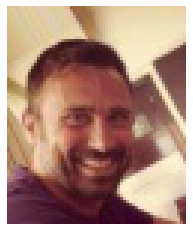

True Label:  tensor(1)
Model output:  tensor([-0.6613,  0.6611])
File name:  178530.jpg


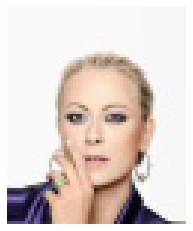

True Label:  tensor(0)
Model output:  tensor([ 0.1694, -0.1693])
File name:  179365.jpg


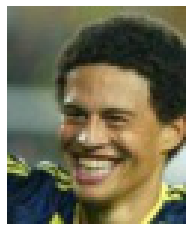

True Label:  tensor(1)
Model output:  tensor([-0.8860,  0.8869])
File name:  174595.jpg


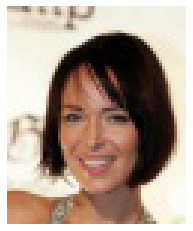

True Label:  tensor(1)
Model output:  tensor([-2.2886,  2.2888])
File name:  165402.jpg


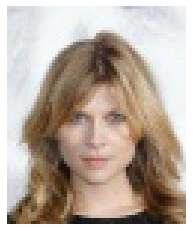

True Label:  tensor(0)
Model output:  tensor([ 0.4015, -0.4018])
File name:  175527.jpg


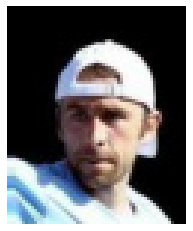

True Label:  tensor(0)
Model output:  tensor([ 1.9119, -1.9116])
File name:  167215.jpg


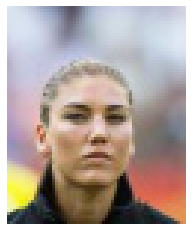

True Label:  tensor(0)
Model output:  tensor([ 0.3089, -0.3089])
File name:  181551.jpg


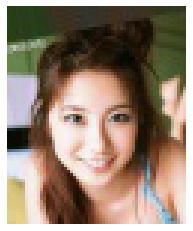

True Label:  tensor(1)
Model output:  tensor([ 0.2179, -0.2171])
File name:  174078.jpg


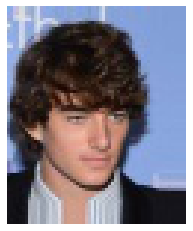

True Label:  tensor(0)
Model output:  tensor([ 1.4746, -1.4745])
File name:  166212.jpg


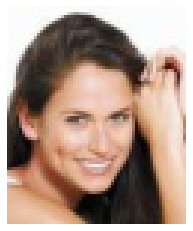

True Label:  tensor(1)
Model output:  tensor([-1.8658,  1.8662])
File name:  178364.jpg


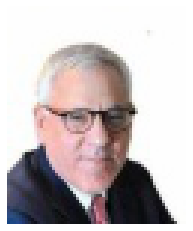

True Label:  tensor(0)
Model output:  tensor([ 0.8257, -0.8257])
File name:  170961.jpg


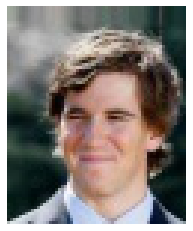

True Label:  tensor(1)
Model output:  tensor([-1.2940,  1.2945])
File name:  177192.jpg


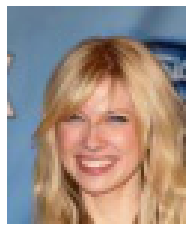

True Label:  tensor(1)
Model output:  tensor([-2.2689,  2.2687])
File name:  182180.jpg


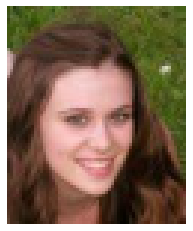

True Label:  tensor(1)
Model output:  tensor([-2.5430,  2.5426])
File name:  172215.jpg


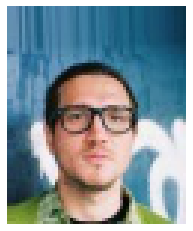

True Label:  tensor(0)
Model output:  tensor([ 1.7787, -1.7785])
File name:  169084.jpg


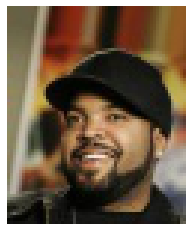

True Label:  tensor(1)
Model output:  tensor([ 0.0579, -0.0576])
File name:  180957.jpg


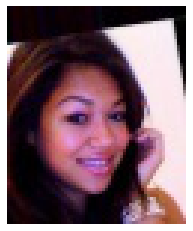

True Label:  tensor(1)
Model output:  tensor([-1.1776,  1.1777])
File name:  163717.jpg


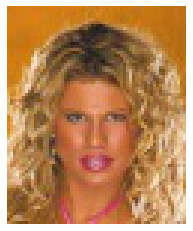

True Label:  tensor(0)
Model output:  tensor([ 0.0280, -0.0285])
File name:  172824.jpg


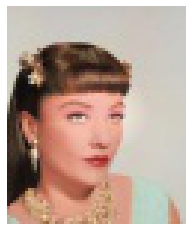

True Label:  tensor(0)
Model output:  tensor([ 1.8482, -1.8483])
File name:  176705.jpg


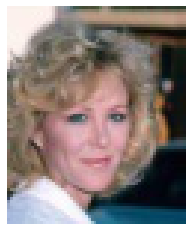

True Label:  tensor(1)
Model output:  tensor([-0.2622,  0.2625])
File name:  175706.jpg


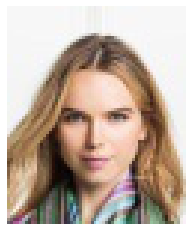

True Label:  tensor(0)
Model output:  tensor([ 1.0534, -1.0537])
File name:  170640.jpg


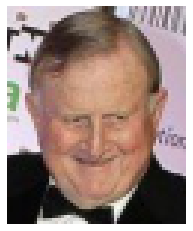

True Label:  tensor(1)
Model output:  tensor([-2.0434,  2.0433])
File name:  172025.jpg


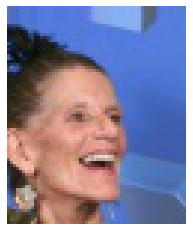

True Label:  tensor(1)
Model output:  tensor([-0.5932,  0.5927])
File name:  174811.jpg


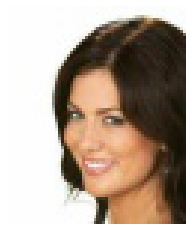

True Label:  tensor(1)
Model output:  tensor([-0.8068,  0.8076])
File name:  176263.jpg


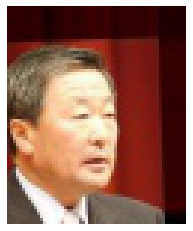

True Label:  tensor(0)
Model output:  tensor([ 1.8105, -1.8106])
File name:  167416.jpg


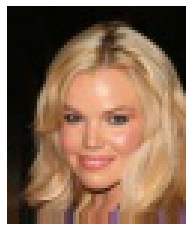

True Label:  tensor(1)
Model output:  tensor([-3.0868,  3.0868])
File name:  174014.jpg


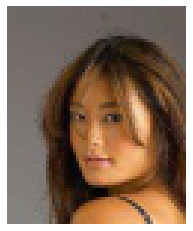

True Label:  tensor(0)
Model output:  tensor([-0.0706,  0.0708])
File name:  168419.jpg


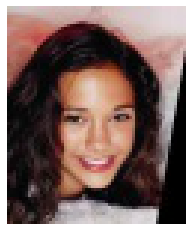

True Label:  tensor(1)
Model output:  tensor([-1.0845,  1.0845])
File name:  181193.jpg


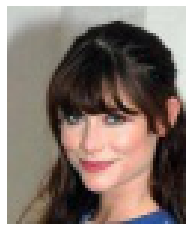

True Label:  tensor(1)
Model output:  tensor([-1.4710,  1.4714])
File name:  170690.jpg


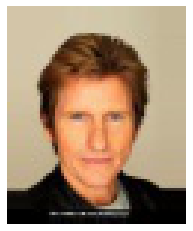

True Label:  tensor(0)
Model output:  tensor([ 1.5108, -1.5112])
File name:  162964.jpg


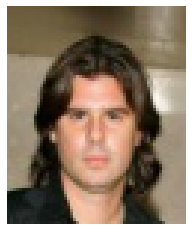

True Label:  tensor(0)
Model output:  tensor([ 2.1849, -2.1847])
File name:  178284.jpg


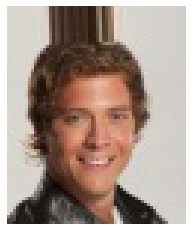

True Label:  tensor(1)
Model output:  tensor([-0.4137,  0.4135])
File name:  181853.jpg


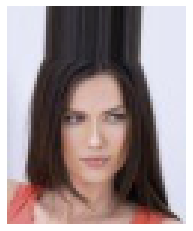

True Label:  tensor(0)
Model output:  tensor([ 0.8257, -0.8259])
File name:  178373.jpg


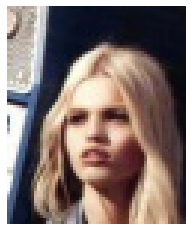

True Label:  tensor(0)
Model output:  tensor([ 1.1481, -1.1484])
File name:  179678.jpg


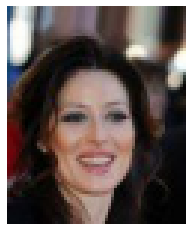

True Label:  tensor(1)
Model output:  tensor([-1.9455,  1.9453])
File name:  169105.jpg


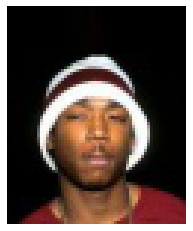

True Label:  tensor(0)
Model output:  tensor([ 0.2867, -0.2869])
File name:  169302.jpg


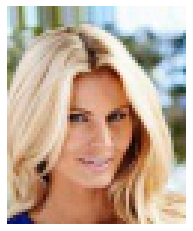

True Label:  tensor(1)
Model output:  tensor([ 0.4105, -0.4102])
File name:  162830.jpg


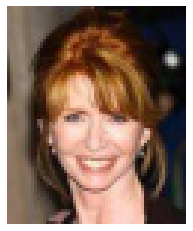

True Label:  tensor(1)
Model output:  tensor([-1.6817,  1.6810])
File name:  167607.jpg


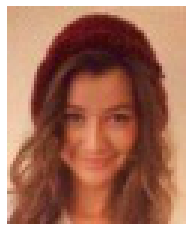

True Label:  tensor(1)
Model output:  tensor([-0.5661,  0.5658])
File name:  174887.jpg


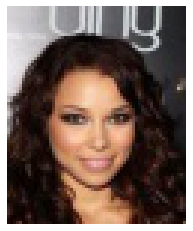

True Label:  tensor(1)
Model output:  tensor([-1.9396,  1.9395])
File name:  165359.jpg


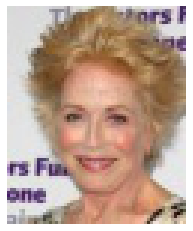

True Label:  tensor(1)
Model output:  tensor([-2.8161,  2.8160])
File name:  165589.jpg


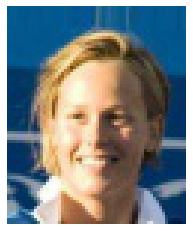

True Label:  tensor(1)
Model output:  tensor([-1.1522,  1.1529])
File name:  180718.jpg


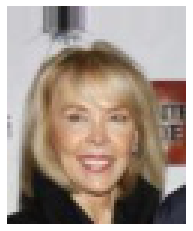

True Label:  tensor(1)
Model output:  tensor([-0.8624,  0.8620])
File name:  178802.jpg


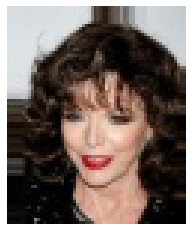

True Label:  tensor(1)
Model output:  tensor([-1.1958,  1.1951])
File name:  172627.jpg


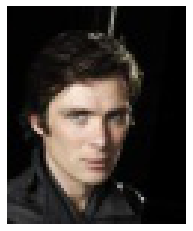

True Label:  tensor(0)
Model output:  tensor([ 1.4651, -1.4647])
File name:  172803.jpg


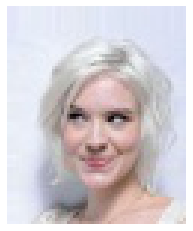

True Label:  tensor(1)
Model output:  tensor([-0.5773,  0.5783])
File name:  164547.jpg


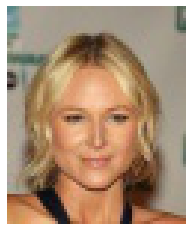

True Label:  tensor(1)
Model output:  tensor([-1.6299,  1.6292])
File name:  170314.jpg


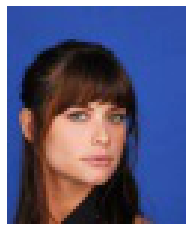

True Label:  tensor(0)
Model output:  tensor([ 2.1314, -2.1314])
File name:  163110.jpg


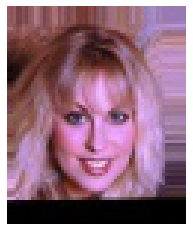

True Label:  tensor(1)
Model output:  tensor([-0.9093,  0.9094])
File name:  177671.jpg


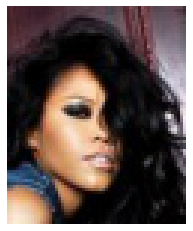

True Label:  tensor(0)
Model output:  tensor([ 1.4009, -1.4004])
File name:  178579.jpg


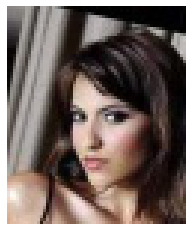

True Label:  tensor(1)
Model output:  tensor([-0.5522,  0.5533])
File name:  171088.jpg


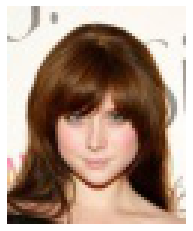

True Label:  tensor(0)
Model output:  tensor([ 1.4619, -1.4628])
File name:  169750.jpg


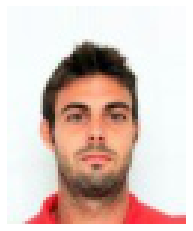

True Label:  tensor(0)
Model output:  tensor([ 3.4007, -3.4005])
File name:  163114.jpg


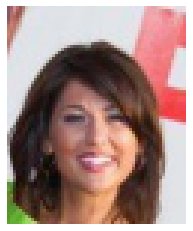

True Label:  tensor(1)
Model output:  tensor([-1.7989,  1.7980])
File name:  175158.jpg


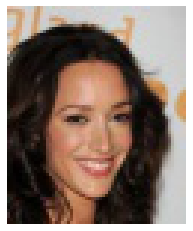

True Label:  tensor(1)
Model output:  tensor([-2.6816,  2.6809])
File name:  181887.jpg


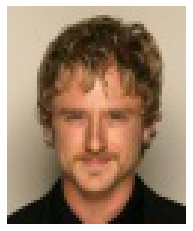

True Label:  tensor(1)
Model output:  tensor([ 1.6699, -1.6702])
File name:  178504.jpg


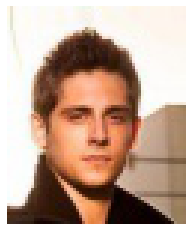

True Label:  tensor(0)
Model output:  tensor([ 2.9279, -2.9275])
File name:  179669.jpg


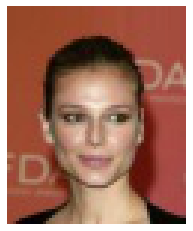

True Label:  tensor(1)
Model output:  tensor([-0.8188,  0.8184])
File name:  163190.jpg


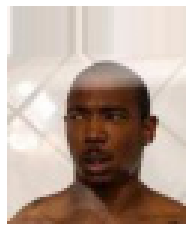

True Label:  tensor(0)
Model output:  tensor([ 0.7680, -0.7677])
File name:  176379.jpg


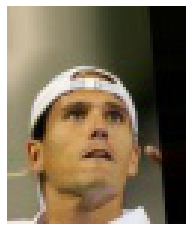

True Label:  tensor(0)
Model output:  tensor([ 1.3327, -1.3329])
File name:  174127.jpg


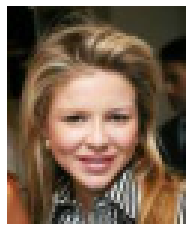

True Label:  tensor(1)
Model output:  tensor([-2.2970,  2.2984])
File name:  167680.jpg


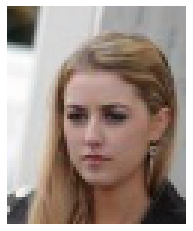

True Label:  tensor(0)
Model output:  tensor([ 1.2095, -1.2090])
File name:  174013.jpg


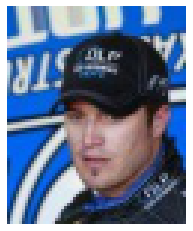

True Label:  tensor(0)
Model output:  tensor([ 0.8289, -0.8287])
File name:  166113.jpg


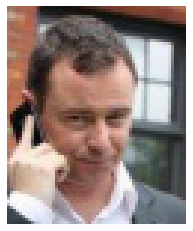

True Label:  tensor(0)
Model output:  tensor([-0.1332,  0.1326])
File name:  166173.jpg


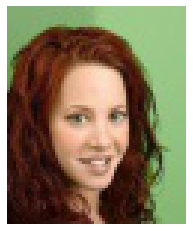

True Label:  tensor(1)
Model output:  tensor([ 0.1934, -0.1939])
File name:  162982.jpg


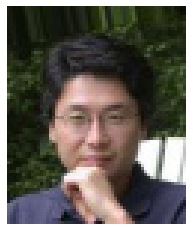

True Label:  tensor(0)
Model output:  tensor([ 0.6528, -0.6524])
File name:  162867.jpg


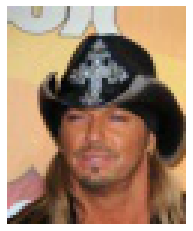

True Label:  tensor(0)
Model output:  tensor([ 0.5642, -0.5641])
File name:  178063.jpg


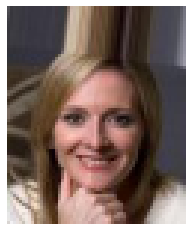

True Label:  tensor(1)
Model output:  tensor([-1.3591,  1.3589])
File name:  174467.jpg


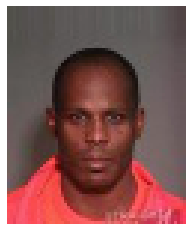

True Label:  tensor(0)
Model output:  tensor([ 0.1042, -0.1040])
File name:  177086.jpg


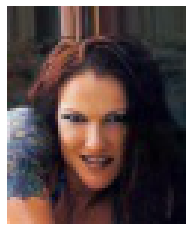

True Label:  tensor(1)
Model output:  tensor([ 0.0908, -0.0908])
File name:  165416.jpg


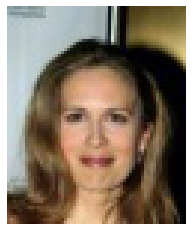

True Label:  tensor(1)
Model output:  tensor([-0.1864,  0.1857])
File name:  168782.jpg


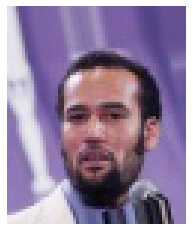

True Label:  tensor(0)
Model output:  tensor([ 1.0375, -1.0373])
File name:  167854.jpg


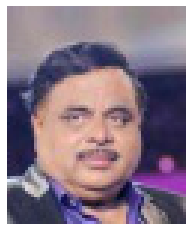

True Label:  tensor(0)
Model output:  tensor([ 0.5918, -0.5912])
File name:  165559.jpg


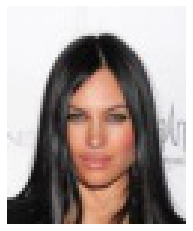

True Label:  tensor(0)
Model output:  tensor([-0.2693,  0.2689])
File name:  177995.jpg


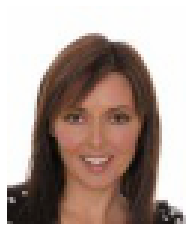

True Label:  tensor(1)
Model output:  tensor([-0.9763,  0.9761])
File name:  165966.jpg


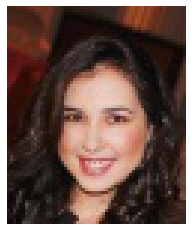

True Label:  tensor(1)
Model output:  tensor([-1.8020,  1.8021])
File name:  163278.jpg


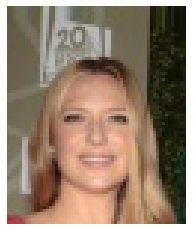

True Label:  tensor(1)
Model output:  tensor([-1.1543,  1.1532])
File name:  173633.jpg


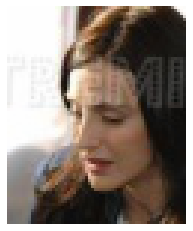

True Label:  tensor(0)
Model output:  tensor([-0.4185,  0.4189])
File name:  177389.jpg


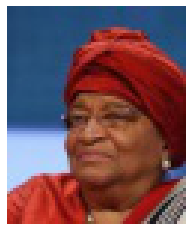

True Label:  tensor(1)
Model output:  tensor([-1.1634,  1.1638])
File name:  168799.jpg


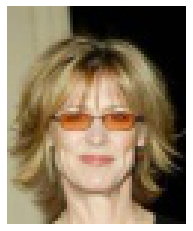

True Label:  tensor(1)
Model output:  tensor([-0.3909,  0.3903])
File name:  163323.jpg


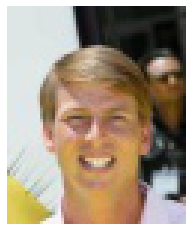

True Label:  tensor(1)
Model output:  tensor([ 0.2115, -0.2124])
File name:  175652.jpg


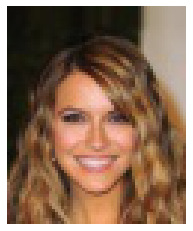

True Label:  tensor(1)
Model output:  tensor([-3.0749,  3.0746])
File name:  173957.jpg


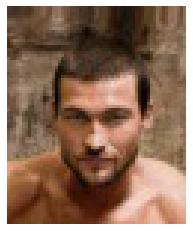

True Label:  tensor(0)
Model output:  tensor([ 0.7684, -0.7685])
File name:  173249.jpg


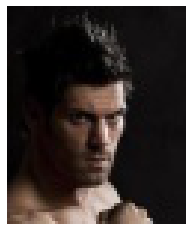

True Label:  tensor(0)
Model output:  tensor([ 0.5642, -0.5640])
File name:  172719.jpg


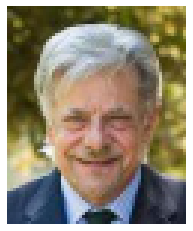

True Label:  tensor(1)
Model output:  tensor([-0.6219,  0.6221])
File name:  165080.jpg


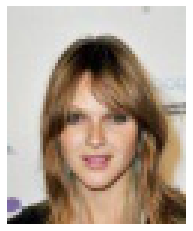

True Label:  tensor(1)
Model output:  tensor([ 0.1055, -0.1060])
File name:  180498.jpg


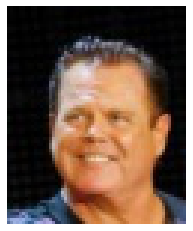

True Label:  tensor(1)
Model output:  tensor([-1.5531,  1.5530])
File name:  163379.jpg


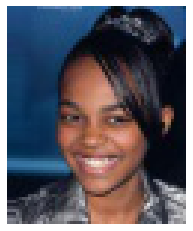

True Label:  tensor(1)
Model output:  tensor([-2.5445,  2.5447])
File name:  166596.jpg


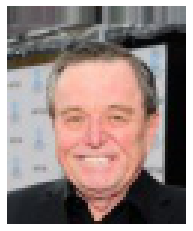

True Label:  tensor(1)
Model output:  tensor([-1.3401,  1.3401])
File name:  170495.jpg


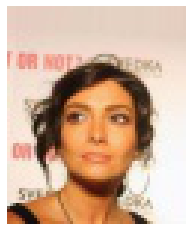

True Label:  tensor(0)
Model output:  tensor([ 1.2325, -1.2327])
File name:  169031.jpg


In [26]:
#calculation predictions on the validation set
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)
val_1_losses,val_1_accs,val_1_lengths,val_0_losses,val_0_accs,val_0_lengths = 0, 0, 0, 0, 0, 0
valid_predictions = valid_predictions.astype(object)
j=0
with torch.no_grad():
    for batch_valid in batch_gen_valid:
        
        output = net(**get_input(batch_valid))
        labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
        if j == 2:
            break
        j+=1
        for i in range(len(batch_valid['file'])):
            plt.figure()
            plt.imshow(np.transpose(vutils.make_grid(batch_valid['image'][i], padding=2,normalize=True).cpu(),(1,2,0)))
            plt.axis('off')
            plt.ioff()
            plt.show()
            print('True Label: ',labels_argmax[i]) 
            print('Model output: ', output['out'][i])
            print('File name: ', batch_valid['file'][i])
            valid_predictions.at[batch_valid['file'][i],'output'] = output['out'][i]
            valid_predictions.at[batch_valid['file'][i],'labels_argmax'] = labels_argmax[i]
            valid_predictions.at[batch_valid['file'][i],'accuracy'] = accuracy(output['out'][i:i+1],labels_argmax[i:i+1])
            valid_predictions.at[batch_valid['file'][i],'criterion'] = criterion(output['out'][i:i+1],labels_argmax[i:i+1])

In [27]:
# Should be equalt to validation accuracy in df
np.mean(valid_predictions['accuracy'])

0.8125

In [28]:
#calculating accuracies for all protected attributes
attributes = matched.iloc[:,0:-1].drop('Smiling',axis=1).columns
df_att = pd.DataFrame(index = attributes, columns=['val_1_loss','val_1_acc','val_0_loss','val_0_acc','val_1_FP','val_1_TP','val_0_FP','val_0_TP','val_1_FN','val_0_FN'])
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)
for att in range(0,len(attributes)):
    print(attributes[att])
    
    att_ = valid_predictions.iloc[:][attributes[att]]
    t_ = valid_predictions.iloc[:]['target']
    
    att_1 = np.where(att_==1)
    att_0 = np.where(att_==0)
    
    att_1_t_1 = np.where((att_==1) & (t_==1))
    att_0_t_1 = np.where((att_==0) & (t_==1))
    att_1_t_0 = np.where((att_==1) & (t_==0))
    att_0_t_0 = np.where((att_==0) & (t_==0))
    
    df_att.iloc[att]['val_1_loss'] = np.mean(valid_predictions.iloc[att_1]['criterion'])
    df_att.iloc[att]['val_1_acc'] = np.mean(valid_predictions.iloc[att_1]['accuracy'])
    df_att.iloc[att]['val_0_loss'] = np.mean(valid_predictions.iloc[att_0]['criterion'])
    df_att.iloc[att]['val_0_acc'] = np.mean(valid_predictions.iloc[att_0]['accuracy'])
    df_att.iloc[att]['val_1_FP'] = 1-np.mean(valid_predictions.iloc[att_1_t_0]['accuracy'])
    df_att.iloc[att]['val_0_FP'] = 1-np.mean(valid_predictions.iloc[att_0_t_0]['accuracy'])
    df_att.iloc[att]['val_1_TP'] = np.mean(valid_predictions.iloc[att_1_t_1]['accuracy'])
    df_att.iloc[att]['val_0_TP'] = np.mean(valid_predictions.iloc[att_0_t_1]['accuracy'])
    df_att.iloc[att]['val_1_FN'] = 1-np.mean(valid_predictions.iloc[att_1_t_1]['accuracy'])
    df_att.iloc[att]['val_0_FN'] = 1-np.mean(valid_predictions.iloc[att_0_t_1]['accuracy'])

5_o_Clock_Shadow
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald
Bangs
Big_Lips
Big_Nose
Black_Hair
Blond_Hair
Blurry
Brown_Hair
Bushy_Eyebrows
Chubby
Double_Chin
Eyeglasses
Goatee
Gray_Hair
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Narrow_Eyes
No_Beard
Oval_Face
Pale_Skin
Pointy_Nose
Receding_Hairline
Rosy_Cheeks
Sideburns
Straight_Hair
Wavy_Hair
Wearing_Earrings
Wearing_Hat
Wearing_Lipstick
Wearing_Necklace
Wearing_Necktie
Young


In [29]:
df_att['TP_OR'] = df_att['val_1_TP'] /df_att['val_0_TP'] 
df_att['FP_OR'] = df_att['val_1_FP'] /df_att['val_0_FP']
df_att['acc_ratio'] = df_att['val_1_acc'] /df_att['val_0_acc']
df_att['FN_OR'] = df_att['val_1_FN'] /df_att['val_0_FN'] 
df_att['TP_OR'] = pd.to_numeric(df_att['TP_OR'])
df_att['FP_OR'] = pd.to_numeric(df_att['FP_OR'])
df_att['acc_ratio'] = pd.to_numeric(df_att['acc_ratio'])
df_att['FN_OR'] = pd.to_numeric(df_att['FN_OR'])


In [30]:
df_att = df_att.sort_values('acc_ratio')

In [34]:
df_att

val_1_loss val_1_acc val_0_loss val_0_acc   val_1_FP  \
Sideburns             0.669443     0.625   0.360932     0.825  0.0909091   
Goatee                0.599503  0.692308   0.368482   0.81893   0.111111   
5_o_Clock_Shadow      0.575719       0.7   0.354262  0.827434  0.0588235   
Male                  0.545207      0.75   0.281218      0.85  0.0689655   
Bushy_Eyebrows        0.607787      0.75   0.347703  0.821429     0.0625   
Mouth_Slightly_Open   0.397451  0.781955   0.361575  0.845528  0.0714286   
Narrow_Eyes           0.473729      0.76   0.370093  0.818182       0.25   
Young                 0.388517  0.797927   0.354779  0.857143   0.139785   
Wearing_Hat           0.622186  0.769231   0.367269  0.814815          0   
Black_Hair            0.440721  0.777778   0.364039  0.821782   0.172414   
Receding_Hairline     0.327014  0.785714   0.383292   0.81405          0   
Bags_Under_Eyes       0.373045  0.791667   0.381868  0.817308      0.125   
Straight_Hair          0.44097  0.795918   0.365832  0.816425   0.148148   
Big_Nose              0.381014       0.8   0.379969  0.816327   0.153846   
Big_Lips              0.378056  0.804348   0.380687  0.814286   0.148148   
Brown_Hair             0.33354  0.805556   0.398478  0.815217   0.114286   
Attractive             0.38275  0.814286   0.377153  0.810345   0.153846   
Pointy_Nose           0.329817  0.820513   0.402298  0.808989   0.230769   
Arched_Eyebrows       0.317183  0.830769   0.401664  0.806283        0.2   
Double_Chin           0.413662  0.846154   0.378424    0.8107          0   
High_Cheekbones       0.309369     0.832   0.447814  0.793893   0.230769   
Gray_Hair             0.266945  0.857143   0.383398  0.811245          0   
Heavy_Makeup          0.279297  0.840708   0.459959   0.79021   0.228571   
No_Beard              0.345613  0.821596   0.551607  0.767442   0.138298   
Wearing_Lipstick      0.287886  0.842105   0.480049  0.780488   0.222222   
Wearing_Earrings      0.261403  0.865385   0.410499   0.79902   0.272727   
Wavy_Hair             0.312703  0.858974   0.409797  0.792135  0.0967742   
Eyeglasses            0.340638  0.882353   0.383029  0.807531  0.0714286   
Wearing_Necktie       0.262504  0.882353   0.388587  0.807531          0   
Wearing_Necklace      0.240242  0.896552   0.398096  0.801762   0.181818   
Blond_Hair            0.258964  0.891304   0.406773  0.795238     0.0625   
Mustache              0.381537  0.916667   0.380149  0.807377          0   
Rosy_Cheeks           0.187204  0.913043   0.399266  0.802575   0.666667   
Chubby                0.344607  0.928571   0.382274  0.805785          0   
Blurry                0.263404  0.928571   0.386971  0.805785   0.166667   
Oval_Face             0.268947  0.919355   0.415773  0.778351  0.0434783   
Bangs                 0.213717  0.957447   0.417656  0.779904          0   
Bald                   0.31181         1   0.381025  0.810277          0   
Pale_Skin             0.241135         1   0.387054  0.803279          0   

                     val_1_TP   val_0_FP  val_0_TP   val_1_FN  val_0_FN  \
Sideburns                   0   0.126126  0.782946          1  0.217054   
Goatee                   0.25   0.123894  0.769231       0.75  0.230769   
5_o_Clock_Shadow     0.384615   0.133333  0.793388   0.615385  0.206612   
Male                 0.473684   0.171875  0.864583   0.526316  0.135417   
Bushy_Eyebrows         0.5625   0.132075  0.779661     0.4375  0.220339   
Mouth_Slightly_Open  0.742857   0.138298  0.793103   0.257143  0.206897   
Narrow_Eyes          0.764706   0.114035  0.752137   0.235294  0.247863   
Young                    0.74  0.0689655  0.794118       0.26  0.205882   
Wearing_Hat              0.25   0.132743  0.769231       0.75  0.230769   
Black_Hair               0.72   0.107527  0.761468       0.28  0.238532   
Receding_Hairline       0.625    0.12931  0.761905      0.375  0.238095   
Bags_Under_Eyes          0.75   0.122642  0.754902       0.25  0.245098   
Stra

In [31]:
df_att2 = df_att.loc[['Rosy_Cheeks','Gray_Hair','Mustache','Sideburns','Arched_Eyebrows','Attractive','Bags_Under_Eyes','Bald','Bangs','Big_Lips','Big_Nose','Chubby','Double_Chin','Heavy_Makeup','Eyeglasses','Goatee','High_Cheekbones','Pale_Skin','Male','Mouth_Slightly_Open','Young']].sort_values('acc_ratio')

In [32]:
df_att2[['acc_ratio','FN_OR','FP_OR']]

acc_ratio     FN_OR     FP_OR
Sideburns             0.757576  4.607143  0.720779
Goatee                0.845381  3.250000  0.896825
Male                  0.882353  3.886640  0.401254
Mouth_Slightly_Open   0.924812  1.242857  0.516484
Young                 0.930915  1.262857  2.026882
Bags_Under_Eyes       0.968627  1.020000  1.019231
Big_Nose              0.980000  0.941176  1.342657
Big_Lips              0.987796  1.080827  1.279461
Attractive            1.004863  0.627273  1.538462
Arched_Eyebrows       1.030370  0.532479  1.854545
Double_Chin           1.043733  0.896057  0.000000
High_Cheekbones       1.048000  0.235714  2.096154
Gray_Hair             1.056577  1.015625  0.000000
Heavy_Makeup          1.063905  0.312152  2.840816
Eyeglasses            1.092655  1.364583  0.551020
Mustache              1.135364  1.364583  0.000000
Rosy_Cheeks           1.137642  0.000000  6.102564
Chubby                1.152381  0.666667  0.000000
Bangs                 1.227647  0.295699  0.000000
Bald                  1.234146  0.000000  0.000000
Pale_Skin             1.244898  0.000000  0.000000

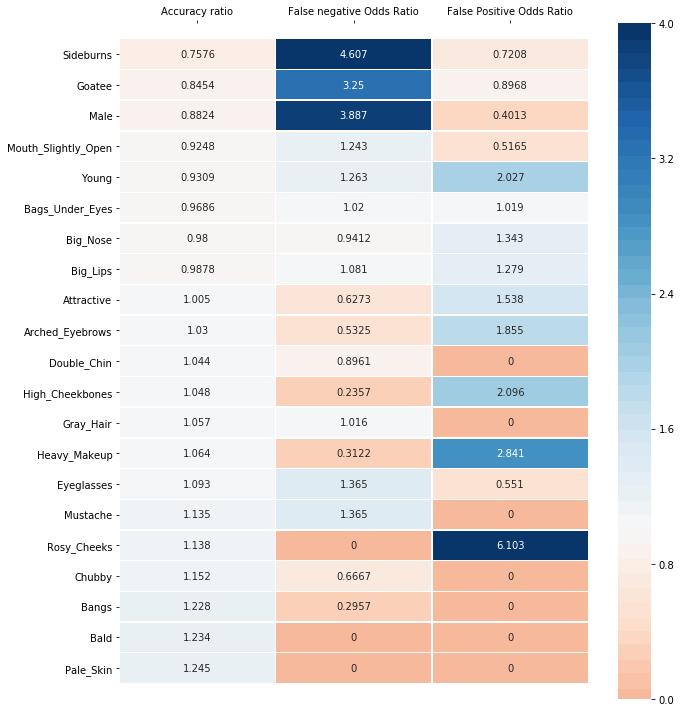

In [33]:
plt.figure(figsize = (10,10))
cmap=sns.color_palette("RdBu",70)
heatmap_kwargs = dict(vmin=0, vmax=4, cmap=cmap,annot=True, linewidths=.5, fmt='.4g')
ax = sns.heatmap(df_att2[['acc_ratio','FN_OR','FP_OR']], center=1.0, **heatmap_kwargs)
ax.set_xticklabels(['Accuracy ratio','False negative Odds Ratio','False Positive Odds Ratio'])
ax.set_yticklabels(list(df_att2.index))
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.xaxis.set_ticks_position('top')
plt.tight_layout()
plt.savefig('heat.png',dpi=500)

In [42]:
#funtion to show image along with output and tru target
def show_batch(sample_batched, bias_idx):
    """Show image with landmarks for a batch of samples."""
    images_batch, target_batch, bias = \
            sample_batched['image'], sample_batched['target'], sample_batched['attributes'][:,bias_idx]
    
    batch_size = len(images_batch)
    pred_label = torch.max(get_labels(sample_batched), 1)[1]
    
    for i in range(batch_size):

        #grid = utils.make_grid(images_batch)
        plt.figure()
        plt.imshow(np.transpose(vutils.make_grid(images_batch[i], padding=2,normalize=True).cpu(),(1,2,0)))
        plt.axis('off')
        plt.ioff()
        plt.show()
        print(target_batch[i])
        #print(bias[i])
        print('Output of NN: ',output['out'][i])
        print('Predicted label: ', pred_label[i])

In [45]:
batch_valid

{'file': ['charlotte.jpg'],
 'image': tensor([[[[199., 199., 199.,  ..., 217., 216., 216.],
           [202., 202., 202.,  ..., 219., 219., 219.],
           [202., 202., 202.,  ..., 220., 220., 220.],
           ...,
           [ 59.,  58.,  52.,  ...,  93.,  84.,  75.],
           [ 58.,  57.,  52.,  ...,  93.,  85.,  74.],
           [ 60.,  60.,  52.,  ...,  93.,  82.,  70.]],
 
          [[195., 195., 195.,  ..., 213., 212., 212.],
           [198., 198., 198.,  ..., 215., 215., 215.],
           [198., 198., 198.,  ..., 216., 216., 216.],
           ...,
           [ 17.,  18.,  15.,  ...,  43.,  37.,  28.],
           [ 16.,  17.,  15.,  ...,  43.,  35.,  27.],
           [ 18.,  20.,  17.,  ...,  43.,  32.,  22.]],
 
          [[184., 184., 184.,  ..., 204., 203., 203.],
           [187., 187., 187.,  ..., 206., 206., 206.],
           [187., 187., 187.,  ..., 207., 207., 207.],
           ...,
           [ 27.,  27.,  23.,  ...,  54.,  47.,  38.],
           [ 26.,  26.,  23.,

<Figure size 432x288 with 0 Axes>

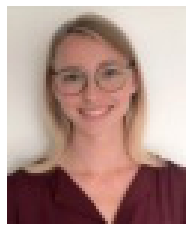

tensor([0., 1.], dtype=torch.float64)


KeyError: 0

In [44]:
plt.figure()
show_batch(batch_valid,21)
plt.axis('off')
plt.ioff()
plt.show()

In [50]:
IMAGE_SHAPE = [73,60,3]
# Root directory for dataset
dataroot = 'C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness'
# Paths to data
VALID_PATH = dataroot + "\\images_resize\\valid.csv"  
IMAGE_PATHS = "C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness\\images_resize"
TARGET_COL = 'Smiling' #'Smiling'
NUM_CLASSES = 2

# valid data
data_valid = data_utils.CelebADataset(VALID_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)

In [51]:
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)
with torch.no_grad():
    for batch_valid in batch_gen_valid:
        output = net(**get_input(batch_valid))
        labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
        ac = accuracy(output['out'],labels_argmax)
        print(ac)

tensor(0.8000)


In [52]:
output

{'out': tensor([[-1.7870,  1.7862],
         [-0.1785,  0.1781],
         [-2.7959,  2.7955],
         [-3.3320,  3.3327],
         [ 1.2387, -1.2403]])}

In [53]:
batch_valid

{'file': ['martin.jpg', 'ole.jpg', 'charlotte.jpg', '000108.jpg', 'pratt.jpg'],
 'image': tensor([[[[171., 171., 170.,  ..., 214., 216., 218.],
           [165., 165., 167.,  ..., 216., 218., 220.],
           [160., 160., 162.,  ..., 218., 220., 222.],
           ...,
           [116., 116., 118.,  ...,  75.,  65.,  71.],
           [117., 115., 116.,  ...,  77.,  78.,  82.],
           [112., 110., 110.,  ...,  82.,  79.,  80.]],
 
          [[184., 184., 184.,  ..., 224., 226., 228.],
           [178., 178., 180.,  ..., 226., 228., 230.],
           [170., 173., 175.,  ..., 228., 230., 232.],
           ...,
           [137., 137., 139.,  ...,  80.,  70.,  76.],
           [137., 135., 136.,  ...,  81.,  82.,  86.],
           [132., 130., 130.,  ...,  83.,  80.,  84.]],
 
          [[193., 193., 193.,  ..., 234., 236., 238.],
           [187., 187., 189.,  ..., 236., 238., 240.],
           [180., 182., 184.,  ..., 238., 240., 242.],
           ...,
           [128., 128., 130.,  .